#### Competition: https://www.kaggle.com/c/demand-forecasting-kernels-only

In [1]:
# The code was removed by Watson Studio for sharing.

## ARIMA model definition and training

#### Install required package

In [1]:
!conda install -c conda-forge lightgbm statsmodels

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - lightgbm
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.4.16          |           py36_0         142 KB  conda-forge
    conda-4.5.11               |           py36_0         625 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         767 KB

The following packages will be UPDATED:

    certifi: 2018.4.16-py36_0 --> 2018.4.16-py36_0 conda-forge
    conda:   4.5.11-py36_0    --> 4.5.11-py36_0    conda-forge

Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting. 



In [4]:
import pandas as pd
import numpy as np
import path
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

In [92]:
try:
    _file = project.get_file('adsc.etl.csv.1.csv')
except:
    _file = path.Path('adsc.etl.csv.1.csv')

In [93]:
df_train = pd.read_csv(_file)
df_train.head()

,date,store,item,sales,year-month,month,day-of-week,year,day-of-year
0,2013-01-01,1,1,13,2013-01,1,1,2013,1
1,2013-01-01,7,12,26,2013-01,1,1,2013,1
2,2013-01-01,7,46,27,2013-01,1,1,2013,1
3,2013-01-01,8,12,54,2013-01,1,1,2013,1
4,2013-01-01,9,12,35,2013-01,1,1,2013,1


In [94]:
#import lightgbm as lgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

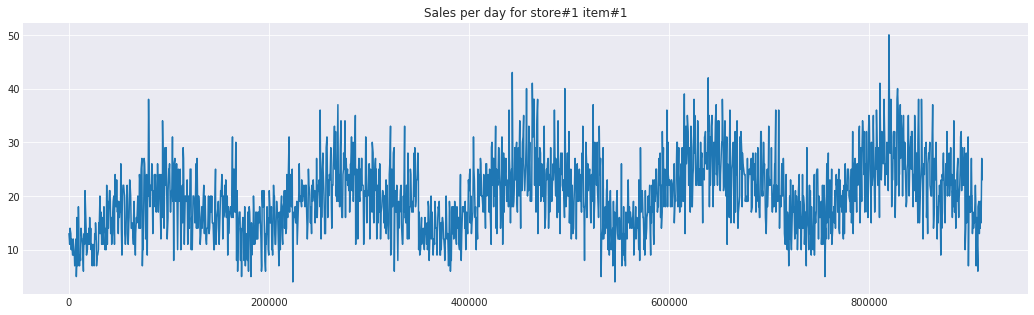

In [95]:
df_store1_item1 = df_train[(df_train['store'] == 1) & (df_train['item'] == 1)][['date', 'sales']]
df_store1_item1['sales'].plot(figsize=(18, 5), title="Sales per day for store#1 item#1")

<Figure size 432x288 with 0 Axes>

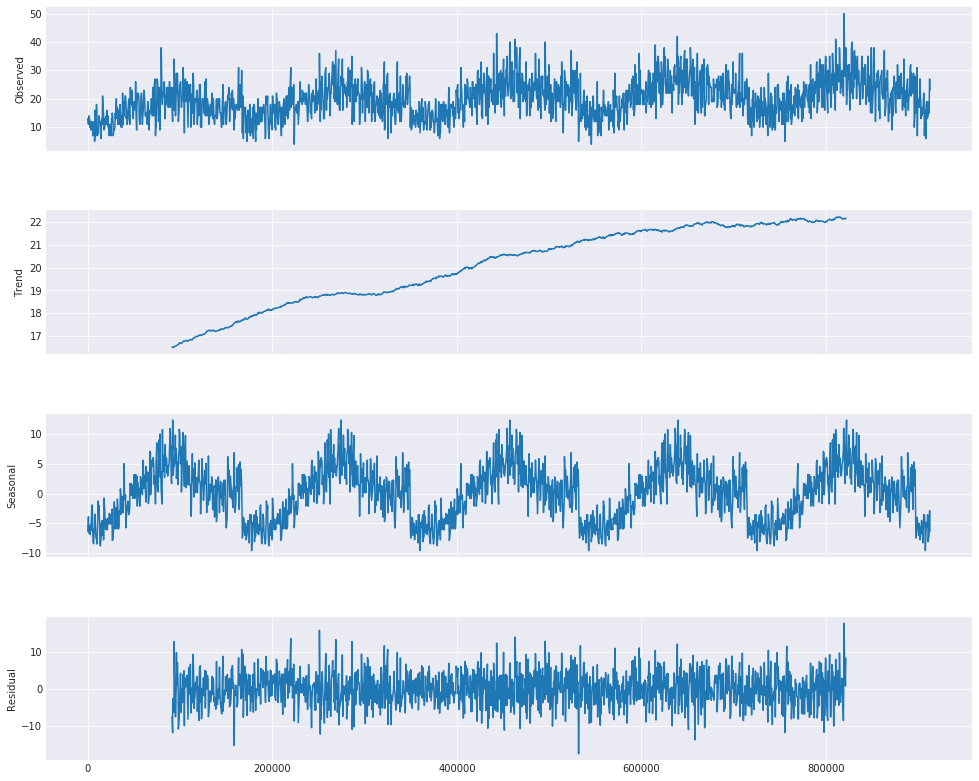

In [96]:
# borrowed from https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_store1_item1['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

### Observation

The plots confirm what we have observed before regarding the up going trend over the years and the years pattern.
This means the data is not [stationary](https://en.wikipedia.org/wiki/Stationary_process).

We need to stationarize the data: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

In [97]:
# borrowed from https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

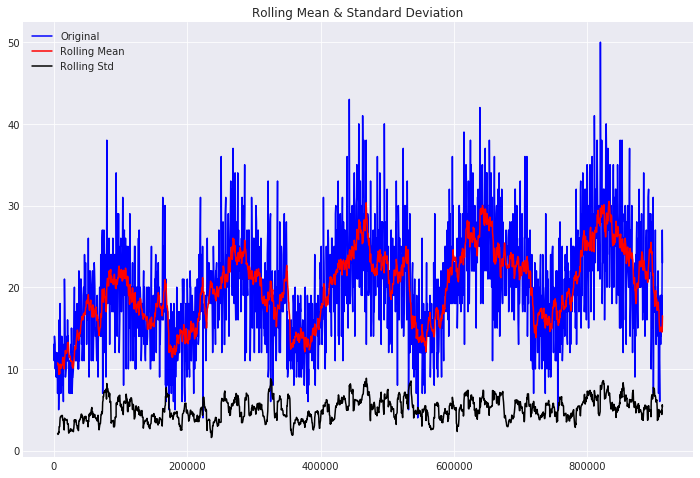

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [98]:
test_stationarity(df_store1_item1['sales'])

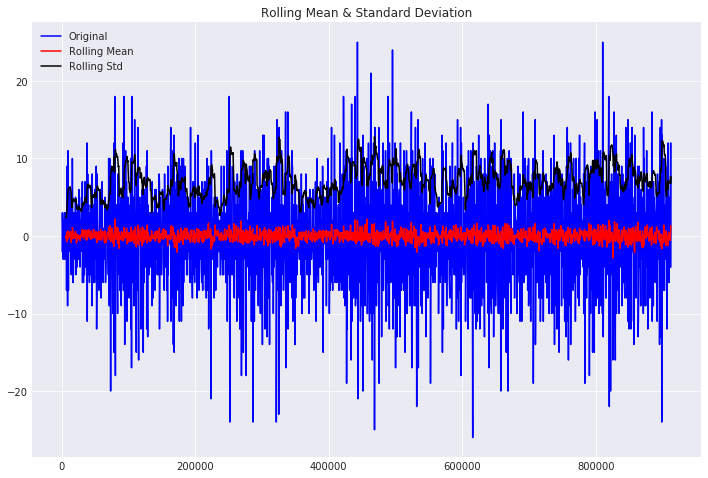

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [99]:
# stationarize data

first_diff = df_store1_item1['sales'] - df_store1_item1['sales'].shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

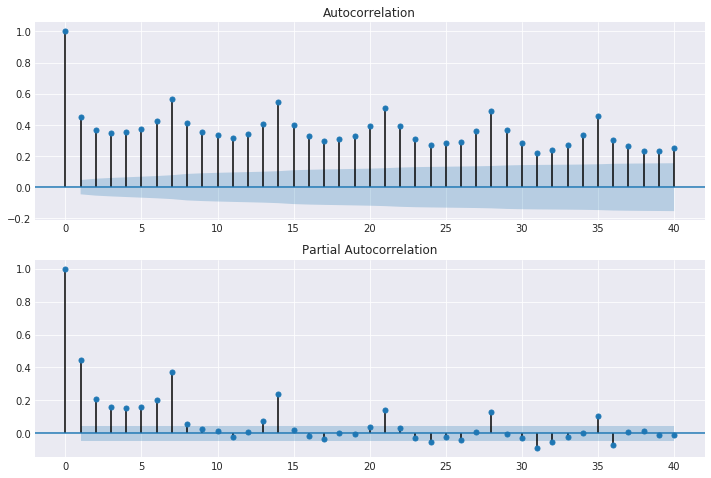

In [100]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_store1_item1.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_store1_item1.sales, lags=40, ax=ax2)# , lags=40

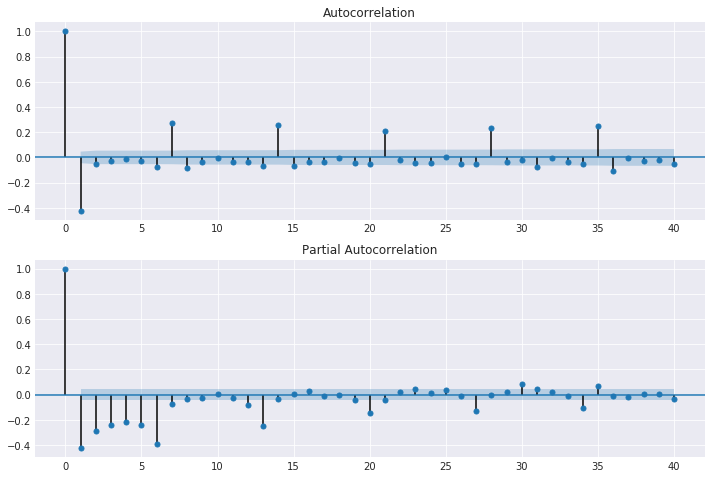

In [101]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)# , lags=40

In [142]:
df_store1_item1.set_index('date', inplace=True);

In [143]:
arima_mod6 = sm.tsa.ARIMA(df_store1_item1.sales, (6,1,0)).fit(disp=False)
print(arima_mod6.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Wed, 03 Oct 2018   AIC                          11211.335
Time:                        08:57:24   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

NormaltestResult(statistic=16.426388036637206, pvalue=0.00027105358708298915)


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


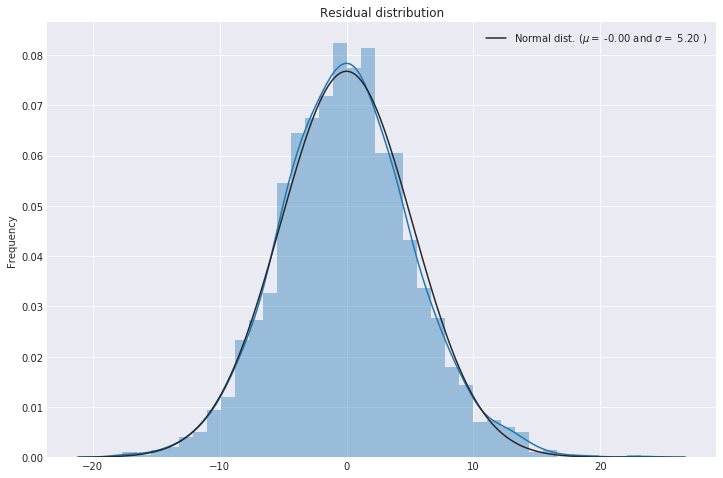

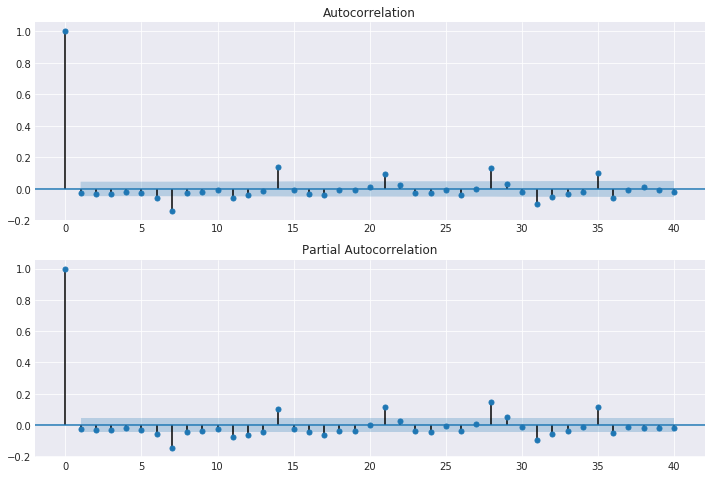

In [146]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

color = sns.color_palette()
sns.set_style('darkgrid')

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [148]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(df_store1_item1.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 03 Oct 2018   AIC                          11209.359
Time:                        08:57:52   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.74269014620744, pvalue=0.0002314040888974918)


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


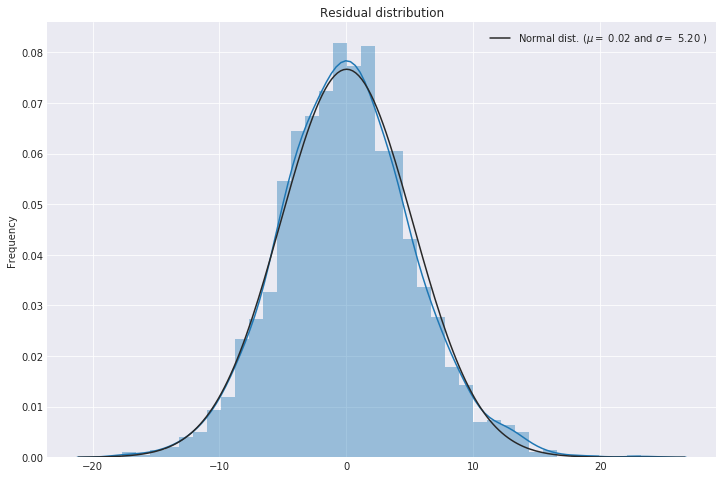

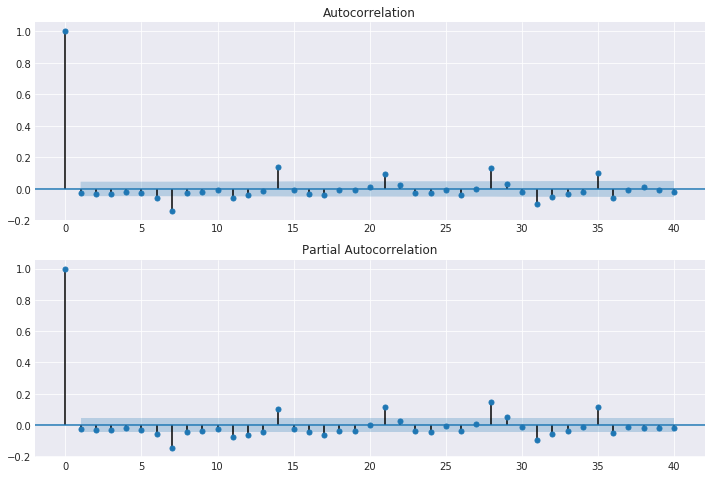

In [149]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [158]:
start = '2017-12-01'
end = '2017-12-31'
df_store1_item1.loc[start:end, 'forecast'] = sarima_mod6.predict(start=start, end=end, dynamic=True)

In [159]:
df_store1_item1['forecast']

date
2013-01-01          NaN
2013-01-02          NaN
2013-01-03          NaN
2013-01-04          NaN
2013-01-05          NaN
2013-01-06          NaN
2013-01-07          NaN
2013-01-08          NaN
2013-01-09          NaN
2013-01-10          NaN
2013-01-11          NaN
2013-01-12          NaN
2013-01-13          NaN
2013-01-14          NaN
2013-01-15          NaN
2013-01-16          NaN
2013-01-17          NaN
2013-01-18          NaN
2013-01-19          NaN
2013-01-20          NaN
2013-01-21          NaN
2013-01-22          NaN
2013-01-23          NaN
2013-01-24          NaN
2013-01-25          NaN
2013-01-26          NaN
2013-01-27          NaN
2013-01-28          NaN
2013-01-29          NaN
2013-01-30          NaN
                ...    
2017-12-02    22.993063
2017-12-03    20.583502
2017-12-04    15.987086
2017-12-05    17.854591
2017-12-06    22.112330
2017-12-07    18.483074
2017-12-08    20.224622
2017-12-09    20.787363
2017-12-10    19.721672
2017-12-11    18.235902
2017-12-12 

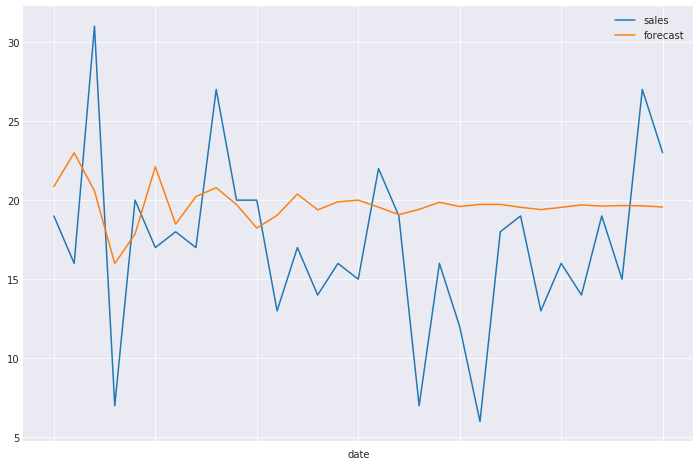

In [160]:
df_store1_item1[['sales', 'forecast']].loc[start:end, ['sales', 'forecast']].plot(figsize=(12, 8))

### Model evaluation

In [163]:
# https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [164]:
smape_kun(df_store1_item1[start:end]['sales'], df_store1_item1[start:end]['forecast'])

MAPE: 38.06 % 
SMAPE: 27.80 %


### In order to predict for all 10 stores and 50 items, this whole procedure would have to be repeated 500 (50 * 10) times.